## Needed Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from xgboost import plot_importance, plot_tree

### Importing CSV Files and preprocessing ETH Data

In [62]:
# Ethereum Prices and dates
df_eth_prices = pd.read_csv("ETH_Historical_Price.csv") 

# Turn timestamps into dates
df_eth_prices['timestamp'] = [dt.datetime.fromtimestamp(i).strftime('%d-%m-%Y') for i in df_eth_prices['timestamp']]

# Reverse the dataframe based on the dates
df_eth_prices = df_eth_prices.iloc[::-1]

# Preprocess the data
df_eth_prices.drop(['high','low','close'], 1, inplace=True)

# Converting timestamp dates as a datetime object
datelist_train = list(df_eth_prices['timestamp'])
datelist_train = [dt.datetime.strptime(date, '%d-%m-%Y').date() for date in datelist_train]
df_eth_prices['timestamp'] = datelist_train
df_eth_prices.index = df_eth_prices['timestamp']
#df_eth_prices = df_eth_prices.set_index('timestamp')
df_eth_prices = df_eth_prices[513:1249]
df_eth_prices

,timestamp,open
timestamp,,
2017-01-01,2017-01-01,8.14
2017-01-02,2017-01-02,8.33
2017-01-03,2017-01-03,9.59
2017-01-04,2017-01-04,10.88
2017-01-05,2017-01-05,10.20
...,...,...
2019-01-02,2019-01-02,156.57
2019-01-03,2019-01-03,149.44
2019-01-04,2019-01-04,156.04


In [63]:
# Implementing weekly prices and adding them to the ethereum price dataframe

weekly_price_list = []
closing_prices = list(df_eth_prices['open'])

temp_list = []
for i in range(0,len(closing_prices)):
    if (i + 1) % 7 == 0:
        temp_list.append(closing_prices[i])
        weekly_price_list.append(temp_list)
        temp_list = []
    else:
        temp_list.append(closing_prices[i])
        
    
mean_weekly_list = []    
for i in weekly_price_list:
    mean_weekly_list.append(np.mean(i))
    
len(mean_weekly_list)

105

In [64]:
# Reading the ethereum google trends values from 2017 to 2019 then assigning the trend values as integers

trends_weekly_df_eth = pd.read_csv("2017_2019_eth_google_trends.csv")
trends_weekly_df_eth.columns = trends_weekly_df_eth.iloc[0]
trends_weekly_df_eth = trends_weekly_df_eth[1:]
trend_values_eth = trends_weekly_df_eth['Ether: (Dünya Genelinde)']

modify_integers_df = trend_values_eth
new_integers = []
for i in modify_integers_df:
    if(i == "<1"):
        new_integers.append(1)
    else:
        new_integers.append(i)
        
trends_weekly_df_eth.drop(['Ether: (Dünya Genelinde)'], 1, inplace=True)
trends_weekly_df_eth['Trend Values'] = new_integers
trends_weekly_df_eth['Trend Values'] = trends_weekly_df_eth['Trend Values'].astype("int")
trends_weekly_df_eth

Hafta,Trend Values
2017-01-01,2
2017-01-08,2
2017-01-15,3
2017-01-22,3
2017-01-29,1
...,...
2018-12-02,15
2018-12-09,10
2018-12-16,20
2018-12-23,22


In [72]:
main_df = pd.DataFrame() 
main_df['Trend Values'] = trends_weekly_df_eth['Trend Values']
main_df['Mean Weekly Prices'] = mean_weekly_list
main_df['Mean Weekly Prices'] = main_df['Mean Weekly Prices'].astype("float")
main_df

,Trend Values,Mean Weekly Prices
2017-01-01,2,9.570000
2017-01-08,2,10.031429
2017-01-15,3,10.248571
2017-01-22,3,10.601429
2017-01-29,1,10.794286
...,...,...
2018-12-02,15,101.580000
2018-12-09,10,88.321429
2018-12-16,20,104.018571
2018-12-23,22,132.825714


## Graphs to visualize the Ethereum data

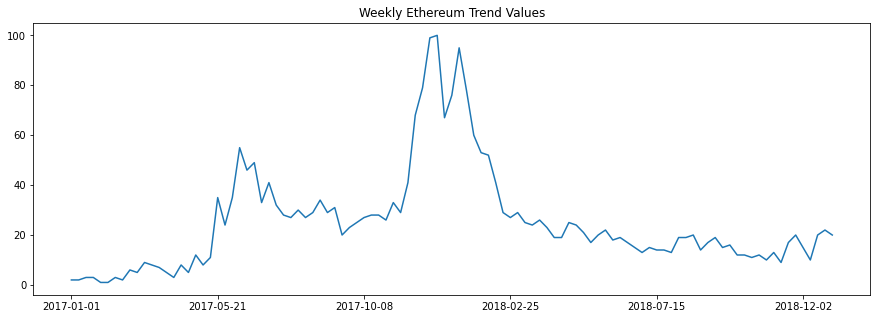

In [76]:
# Mean Weekly Prices For Ethereum
main_df['Trend Values'].plot(figsize=(15, 5))
plt.title("Weekly Ethereum Trend Values")
plt.show()

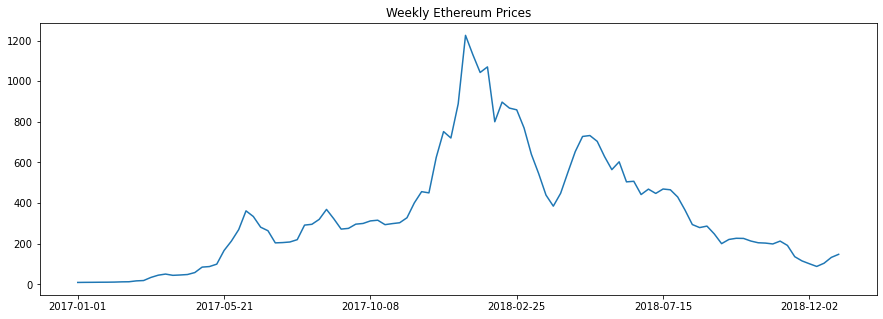

In [75]:
# Mean Weekly Prices For Ethereum
main_df['Mean Weekly Prices'].plot(figsize=(15, 5))
plt.title("Weekly Ethereum Prices")
plt.show()

In [78]:
# creating a main dataframe to use these data on other notebooks
'''
main_df.to_csv('trends_prices_ethereum_df_2017_2019.csv')
main_df
'''

"\nmain_df.to_csv('trends_prices_ethereum_df_2017_2019.csv')\nmain_df\n"

In [89]:
# Create a week feature
main_df['Week Feature'] = main_df.index
main_df

,Trend Values,Mean Weekly Prices,Week Feature
2017-01-01,2,9.570000,2017-01-01
2017-01-08,2,10.031429,2017-01-08
2017-01-15,3,10.248571,2017-01-15
2017-01-22,3,10.601429,2017-01-22
2017-01-29,1,10.794286,2017-01-29
...,...,...,...
2018-12-02,15,101.580000,2018-12-02
2018-12-09,10,88.321429,2018-12-09
2018-12-16,20,104.018571,2018-12-16
2018-12-23,22,132.825714,2018-12-23


In [79]:
# Check null values
main_df.isnull().sum()

Trend Values          0
Mean Weekly Prices    0
dtype: int64

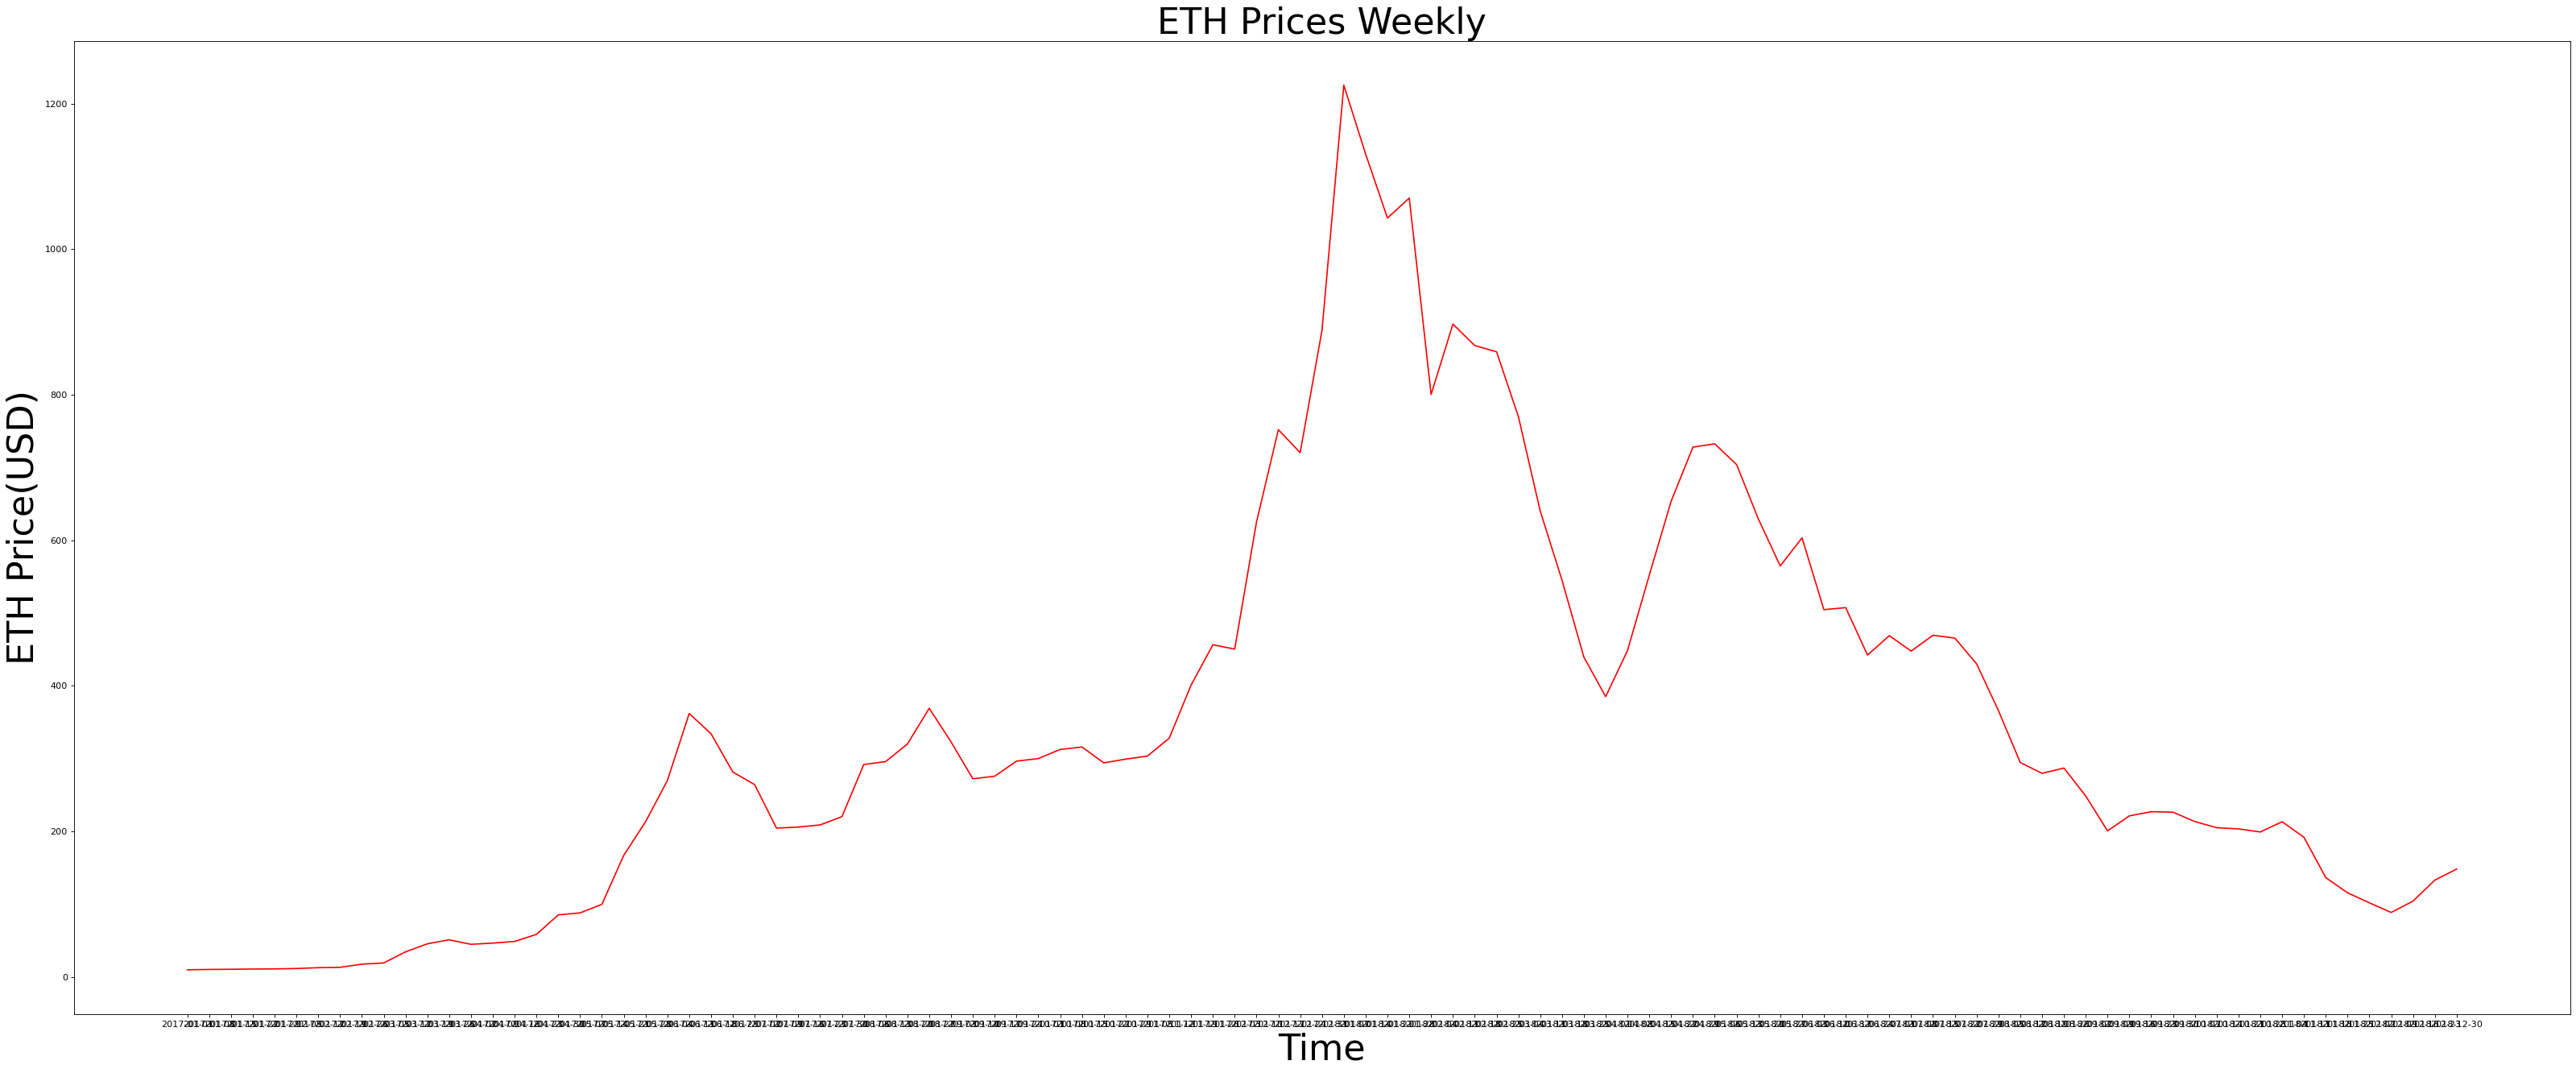

In [83]:

plt.figure(figsize=(50, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(main_df['Mean Weekly Prices'], color='red', label='Real ETH Price')
plt.title('ETH Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD)', fontsize = 40)
plt.show()

### Splitting the data for train and test

In [91]:
# Converting dates as a datetime object

datelist_train = list(main_df['Week Feature'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]
main_df.index = datelist_train
main_df

,Trend Values,Mean Weekly Prices,Week Feature
2017-01-01,2,9.570000,2017-01-01
2017-01-08,2,10.031429,2017-01-08
2017-01-15,3,10.248571,2017-01-15
2017-01-22,3,10.601429,2017-01-22
2017-01-29,1,10.794286,2017-01-29
...,...,...,...
2018-12-02,15,101.580000,2018-12-02
2018-12-09,10,88.321429,2018-12-09
2018-12-16,20,104.018571,2018-12-16
2018-12-23,22,132.825714,2018-12-23


In [92]:
# Splitting the data to train and test based on the prediction day we want

date_string = "21 May, 2018"
#possible parameter %H:%M:%S
dt_onject_split = dt.datetime.strptime(date_string, "%d %B, %Y").date()
data_train = main_df.loc[main_df.index <= dt_onject_split].copy()
data_test = main_df.loc[main_df.index > dt_onject_split].copy()

print("Data train shape",data_train.shape)
print("Data test shape",data_test.shape)

Data train shape (73, 3)
Data test shape (32, 3)


In [97]:
def create_features_with_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['Month'] = df['Hafta'].dt.month
    df['Year'] = df['Hafta'].dt.year
    df['Day of Month'] = df['Hafta'].dt.day

    
    X = df[['Month','Year','Day of Month','Trend Values']]
    if label:
        y = df[label]
        return X, y
    return X



def create_features_without_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['Month'] = df['Hafta'].dt.month
    df['Year'] = df['Hafta'].dt.year
    df['Day of Month'] = df['Hafta'].dt.day

    
    X = df[['Month','Year','Day of Month']]
    if label:
        y = df[label]
        return X, y
    return X

### Create train and test data

In [98]:
X_train, y_train = create_features_with_google_trends(data_train, label='Mean Weekly Prices')
X_test, y_test = create_features_with_google_trends(data_test, label='Mean Weekly Prices')

X_train['Trend Values'] = X_train['Trend Values'].astype(int)
X_test['Trend Values'] = X_test['Trend Values'].astype(int)

X_train

<ipython-input-98-2d8b07437914>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Trend Values'] = X_train['Trend Values'].astype(int)
<ipython-input-98-2d8b07437914>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Trend Values'] = X_test['Trend Values'].astype(int)


,Month,Year,Day of Month,Trend Values
2017-01-01,1,2017,1,2
2017-01-08,1,2017,8,2
2017-01-15,1,2017,15,3
2017-01-22,1,2017,22,3
2017-01-29,1,2017,29,1
...,...,...,...,...
2018-04-22,4,2018,22,25
2018-04-29,4,2018,29,24
2018-05-06,5,2018,6,21
2018-05-13,5,2018,13,17


In [99]:
X_train_second, y_train_second = create_features_without_google_trends(data_train, label='Mean Weekly Prices')
X_test_second, y_test_second = create_features_without_google_trends(data_test, label='Mean Weekly Prices')


X_train_second

,Month,Year,Day of Month
2017-01-01,1,2017,1
2017-01-08,1,2017,8
2017-01-15,1,2017,15
2017-01-22,1,2017,22
2017-01-29,1,2017,29
...,...,...,...
2018-04-22,4,2018,22
2018-04-29,4,2018,29
2018-05-06,5,2018,6
2018-05-13,5,2018,13


## Create an XGBOOST model. 

In [100]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

model_first =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
model_first.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,verbose=True)

[15:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:460.92612	validation_1-rmse:297.69611
[1]	validation_0-rmse:424.88391	validation_1-rmse:277.08054
[2]	validation_0-rmse:403.39883	validation_1-rmse:253.07930
[3]	validation_0-rmse:385.02551	validation_1-rmse:232.64800
[4]	validation_0-rmse:368.85291	validation_1-rmse:220.24767
[5]	validation_0-rmse:355.04526	validation_1-rmse:210.39572
[6]	validation_0-rmse:330.73428	validation_1-rmse:204.46744
[7]	validation_0-rmse:320.66635	validation_1-rmse:194.70837
[8]	validation_0-rmse:311.71558	validation_1-rmse:191.36839
[9]	validation_0-rmse:304.40369	validation_1-rmse:185.60870
[10]	validation_0-rmse:284.84061	validation_1-rmse:171.88098
[11]	validation_0-rmse:279.42001	validation_1-rmse:170.67276
[12]	validation_0-rmse:274.82101	validation_1-rmse:170.06055
[13]	validation_0-rmse:258.93424	validat

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [102]:
data_test['Price_Prediction_With_Trends'] = model_first.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)
data_all

,Trend Values,Mean Weekly Prices,Week Feature,Hafta,Month,Year,Day of Month,Price_Prediction_With_Trends
2018-05-27,22,564.592857,2018-05-27,2018-05-27,5,2018,27,316.674957
2018-06-03,18,603.178571,2018-06-03,2018-06-03,6,2018,3,271.468384
2018-06-10,19,504.468571,2018-06-10,2018-06-10,6,2018,10,319.154846
2018-06-17,17,507.298571,2018-06-17,2018-06-17,6,2018,17,324.742554
2018-06-24,15,442.112857,2018-06-24,2018-06-24,6,2018,24,310.538483
...,...,...,...,...,...,...,...,...
2018-04-22,25,653.477143,2018-04-22,2018-04-22,4,2018,22,NaN
2018-04-29,24,727.901429,2018-04-29,2018-04-29,4,2018,29,NaN
2018-05-06,21,732.414286,2018-05-06,2018-05-06,5,2018,6,NaN
2018-05-13,17,703.872857,2018-05-13,2018-05-13,5,2018,13,NaN


In [ ]:
data_all['Mean Weekly Prices'] = data_all['Mean Weekly Prices'].astype(float)

Text(0.5, 1.0, 'With Google Trends Ethereum Prediction')

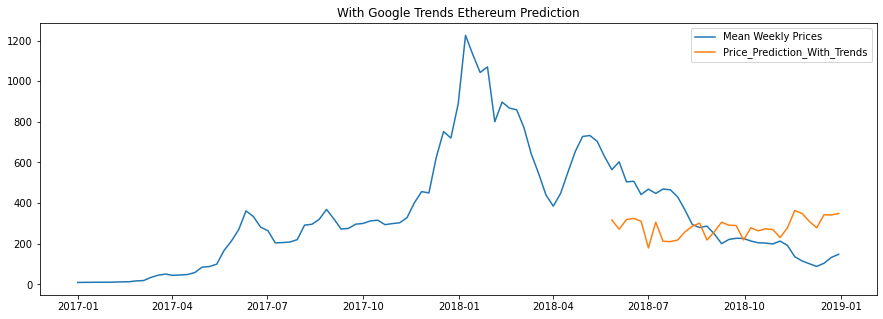

In [121]:
data_all[['Mean Weekly Prices','Price_Prediction_With_Trends']].plot(figsize=(15, 5))
plt.title("With Google Trends Ethereum Prediction")

## Without google trends model

In [104]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
'''
    parameters_dict = {"learning_rate"    : [0.05,0.1, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8],
 "min_child_weight" : [ 5, 7 ],
 "gamma"            : [ 0.3, 0.4 ],
 "colsample_bytree" : [ 0.5 , 0.7 ] }
'''
model_second =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
model_second.fit(X_train_second, y_train_second,eval_set=[(X_train_second, y_train_second), (X_test_second, y_test_second)],early_stopping_rounds=50,verbose=True)

[15:35:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:460.92612	validation_1-rmse:297.69611
[1]	validation_0-rmse:426.04248	validation_1-rmse:241.66267
[2]	validation_0-rmse:404.71295	validation_1-rmse:219.86229
[3]	validation_0-rmse:386.48236	validation_1-rmse:202.01912
[4]	validation_0-rmse:370.32578	validation_1-rmse:191.76706
[5]	validation_0-rmse:356.54819	validation_1-rmse:184.90742
[6]	validation_0-rmse:333.76468	validation_1-rmse:167.69511
[7]	validation_0-rmse:323.90567	validation_1-rmse:165.74083
[8]	validation_0-rmse:314.99695	validation_1-rmse:170.04228
[9]	validation_0-rmse:308.02924	validation_1-rmse:171.37532
[10]	validation_0-rmse:291.27713	validation_1-rmse:180.68387
[11]	validation_0-rmse:285.95010	validation_1-rmse:185.05158
[12]	validation_0-rmse:281.38565	validation_1-rmse:188.86148
[13]	validation_0-rmse:268.11026	validat

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [105]:
data_test['Price_Prediction_Without_Trends'] = model_second.predict(X_test_second)
data_all_second = pd.concat([data_test, data_train], sort=False)
data_all_second['Mean Weekly Prices'] = data_all_second['Mean Weekly Prices'].astype(float)

Text(0.5, 1.0, 'Without Google Trends Ethereum Prediction')

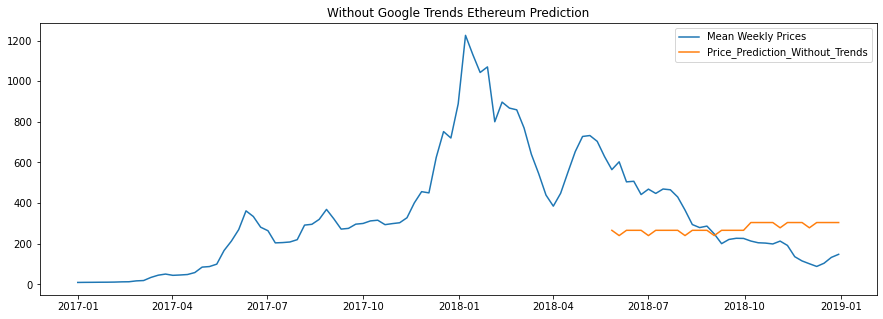

In [120]:
data_all_second[['Mean Weekly Prices','Price_Prediction_Without_Trends']].plot(figsize=(15, 5))
plt.title("Without Google Trends Ethereum Prediction")

In [115]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test, model_first.predict(X_test), squared=False)
rms_second = mean_squared_error(y_test_second, model_second.predict(X_test_second), squared=False)

In [116]:
# With google trends
rms

170.06055496017046

In [117]:
# Without google trends
rms_second

165.7408204740033

In [122]:
ms = mean_squared_error(y_test, model_first.predict(X_test), squared=True)
ms_second = mean_squared_error(y_test_second, model_second.predict(X_test_second), squared=True)

In [123]:
# With google trends
ms

28920.592353361157

In [124]:
# Without google trends
ms_second

27470.019571395787

In [119]:
main_df.corr()

,Trend Values,Mean Weekly Prices
Trend Values,1.000000,0.669545
Mean Weekly Prices,0.669545,1.000000


In [ ]:
# Previously train and test splitting was used for the data
# Now cross validation is used to further enhance our implementation

### Rolling Forecast Origin Implementation

In [127]:
def roll_forecast_orig(train,min_train_size,horizon):
    for i in range(len(train)-min_train_size-horizon+1):
        split_train = train[:min_train_size+i]
        split_val = train[min_train_size+i:min_train_size+i+horizon]
        yield split_train,split_val

### Simple example implementation

In [128]:
series_ex = [2300,5000,6000,9000,2323,5644,7878,4444,2342,3000,3500,5000,7000,8000,9000,8000]
test=series_ex[-2:]
train = series_ex[:-2]

rolling_data = roll_forecast_orig(train,min_train_size=3,horizon=2)

print('Training Set: {0}'.format(train))
print('Test Set: {0}'.format(test))

print('\n')

i= 0
for train_c, val_c in rolling_data:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    i += 1

Training Set: [2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 3000, 3500, 5000, 7000, 8000]
Test Set: [9000, 8000]


Count[1]
Train:	[[2300, 5000, 6000]]
Val:	[[9000, 2323]]
-------
Count[2]
Train:	[[2300, 5000, 6000, 9000]]
Val:	[[2323, 5644]]
-------
Count[3]
Train:	[[2300, 5000, 6000, 9000, 2323]]
Val:	[[5644, 7878]]
-------
Count[4]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644]]
Val:	[[7878, 4444]]
-------
Count[5]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878]]
Val:	[[4444, 2342]]
-------
Count[6]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444]]
Val:	[[2342, 3000]]
-------
Count[7]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342]]
Val:	[[3000, 3500]]
-------
Count[8]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 3000]]
Val:	[[3500, 5000]]
-------
Count[9]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 3000, 3500]]
Val:	[[5000, 7000]]
-------
Count[10]
Train:	[[2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 30

In [129]:
# Splitting the data to train and test based on the prediction day we want

date_string = "21 May, 2018"
#possible parameter %H:%M:%S
dt_onject_split = dt.datetime.strptime(date_string, "%d %B, %Y").date()
data_train = main_df.loc[main_df.index <= dt_onject_split].copy()
data_test = main_df.loc[main_df.index > dt_onject_split].copy()

print("Data train shape",data_train.shape)
print("Data test shape",data_test.shape)

Data train shape (73, 3)
Data test shape (32, 3)


In [130]:
def create_features_with_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['Month'] = df['Hafta'].dt.month
    df['Year'] = df['Hafta'].dt.year
    df['Day of Month'] = df['Hafta'].dt.day

    
    X = df[['Month','Year','Day of Month','Trend Values']]
    if label:
        y = df[label]
        return X, y
    return X

In [131]:
X_train, y_train = create_features_with_google_trends(data_train, label='Mean Weekly Prices')
X_test, y_test = create_features_with_google_trends(data_test, label='Mean Weekly Prices')

X_train['Trend Values'] = X_train['Trend Values'].astype(int)
X_test['Trend Values'] = X_test['Trend Values'].astype(int)

X_train

<ipython-input-131-a7dca86bbf66>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Trend Values'] = X_train['Trend Values'].astype(int)
<ipython-input-131-a7dca86bbf66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Trend Values'] = X_test['Trend Values'].astype(int)


,Month,Year,Day of Month,Trend Values
2017-01-01,1,2017,1,2
2017-01-08,1,2017,8,2
2017-01-15,1,2017,15,3
2017-01-22,1,2017,22,3
2017-01-29,1,2017,29,1
...,...,...,...,...
2018-04-22,4,2018,22,25
2018-04-29,4,2018,29,24
2018-05-06,5,2018,6,21
2018-05-13,5,2018,13,17


In [132]:
rolling_data_x = roll_forecast_orig(X_train,min_train_size=3,horizon=2)
rolling_data_y = roll_forecast_orig(list(y_train),min_train_size=3,horizon=2)


cv_x_train_list = []
cv_x_test_list = []
i= 0
for train_c, val_c in rolling_data_x:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    cv_x_train_list.append(train_c)
    cv_x_test_list.append(val_c)
    i += 1

Count[1]
Train:	[            Month  Year  Day of Month  Trend Values
2017-01-01      1  2017             1             2
2017-01-08      1  2017             8             2
2017-01-15      1  2017            15             3]
Val:	[            Month  Year  Day of Month  Trend Values
2017-01-22      1  2017            22             3
2017-01-29      1  2017            29             1]
-------
Count[2]
Train:	[            Month  Year  Day of Month  Trend Values
2017-01-01      1  2017             1             2
2017-01-08      1  2017             8             2
2017-01-15      1  2017            15             3
2017-01-22      1  2017            22             3]
Val:	[            Month  Year  Day of Month  Trend Values
2017-01-29      1  2017            29             1
2017-02-05      2  2017             5             1]
-------
Count[3]
Train:	[            Month  Year  Day of Month  Trend Values
2017-01-01      1  2017             1             2
2017-01-08      1  2017          

Count[69]
Train:	[            Month  Year  Day of Month  Trend Values
2017-01-01      1  2017             1             2
2017-01-08      1  2017             8             2
2017-01-15      1  2017            15             3
2017-01-22      1  2017            22             3
2017-01-29      1  2017            29             1
...           ...   ...           ...           ...
2018-04-08      4  2018             8            19
2018-04-15      4  2018            15            19
2018-04-22      4  2018            22            25
2018-04-29      4  2018            29            24
2018-05-06      5  2018             6            21

[71 rows x 4 columns]]
Val:	[            Month  Year  Day of Month  Trend Values
2018-05-13      5  2018            13            17
2018-05-20      5  2018            20            20]
-------


In [133]:
cv_y_train_list = []
cv_y_test_list = []
i= 0
for train_c, val_c in rolling_data_y:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    cv_y_train_list.append(train_c)
    cv_y_test_list.append(val_c)

    i += 1

Count[1]
Train:	[[9.569999999999999, 10.031428571428572, 10.248571428571427]]
Val:	[[10.60142857142857, 10.794285714285715]]
-------
Count[2]
Train:	[[9.569999999999999, 10.031428571428572, 10.248571428571427, 10.60142857142857]]
Val:	[[10.794285714285715, 11.29857142857143]]
-------
Count[3]
Train:	[[9.569999999999999, 10.031428571428572, 10.248571428571427, 10.60142857142857, 10.794285714285715]]
Val:	[[11.29857142857143, 12.468571428571428]]
-------
Count[4]
Train:	[[9.569999999999999, 10.031428571428572, 10.248571428571427, 10.60142857142857, 10.794285714285715, 11.29857142857143]]
Val:	[[12.468571428571428, 12.944285714285712]]
-------
Count[5]
Train:	[[9.569999999999999, 10.031428571428572, 10.248571428571427, 10.60142857142857, 10.794285714285715, 11.29857142857143, 12.468571428571428]]
Val:	[[12.944285714285712, 17.275714285714287]]
-------
Count[6]
Train:	[[9.569999999999999, 10.031428571428572, 10.248571428571427, 10.60142857142857, 10.794285714285715, 11.29857142857143, 12.4

In [134]:
def root_mean_squared_sum_of_list(list_value):
    sum_of_list_as_root_mean_squared = 0
    for i in list_value:
        sum_of_list_as_root_mean_squared += np.sqrt(i)
    return sum_of_list_as_root_mean_squared

def calculate_cv_scores(model,cv_x_train_list, cv_x_test_list ,cv_y_train,cv_y_test, metric):
    cv_scores = []
    i=0
    for i in range(len(cv_x_train_list)):
        model.fit(cv_x_train_list[i], cv_y_train[i])
        predictions = model.predict(cv_x_test_list[i])
        score = metric(y_true = cv_y_test[i], y_pred = predictions)
        cv_scores.append(score)
        i += 1
    return root_mean_squared_sum_of_list(np.array(cv_scores)) 


# Cross Validation function
def cross_val_score(cv_x_train_list, cv_x_test_list ,cv_y_train,cv_y_test, metric):

    # Learning rate daha az dene
    parameters_dict = {"learning_rate"    : [0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8],
 "min_child_weight" : [ 5, 7 ],
 "gamma"            : [ 0.3, 0.4 ],
 "colsample_bytree" : [ 0.5 , 0.7 ] }
    
    cv_scores_dict = {}
    i_num = 0
    for l_r in parameters_dict['learning_rate']:
        for m_d in parameters_dict['max_depth']:
            for m_c_w in parameters_dict['min_child_weight']:
                for g in parameters_dict['gamma']:
                    for c_b in parameters_dict['colsample_bytree']:
                        model = xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=m_c_w, booster='gbtree', colsample_bytree = c_b, learning_rate = l_r,max_depth = m_d)
                        hyper_parameter_string = "learning_rate "+str(l_r)+" max_depth "+str(m_d)+" min_child_weight "+str(m_c_w)+" gamma "+str(g)+" colsample_bytree "+str(c_b)
                        cv_score_of_model = calculate_cv_scores(model,cv_x_train_list, cv_x_test_list ,cv_y_train,cv_y_test, metric)
                        i_num = i_num + 1
                        print(str(i_num)+" Error of the model "+ hyper_parameter_string ,cv_score_of_model)
                        cv_scores_dict[hyper_parameter_string] = cv_score_of_model
    
    
    return cv_scores_dict

In [135]:
def find_least_error_hyperparameters(dictionary):
    min_index = 0
    key_list = []
    value_list = []
    for key,item in dictionary.items():
        key_list.append(key)
        value_list.append(item)
    temp_index = 0
    temp = value_list[0]
    for i in range(0,len(value_list)):
        if temp > value_list[i]:
            temp_index = i
            temp = value_list[i]
    return key_list[temp_index], temp

In [136]:
cv_sc = cross_val_score(cv_x_train_list , cv_x_test_list  ,cv_y_train_list, cv_y_test_list , mean_absolute_error)

1 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.5 680.8483769687642
2 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.7 680.8483769687642
3 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.5 680.8483769687642
4 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.7 680.8483769687642
5 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.3 colsample_bytree 0.5 683.3107862770821
6 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.3 colsample_bytree 0.7 683.3107862770821
7 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.4 colsample_bytree 0.5 683.3107862770821
8 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.4 colsample_bytree 0.7 683.3107862770821
9 Error of the model learning_rate 0.2 max_depth

70 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.3 colsample_bytree 0.7 707.3677514234707
71 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.4 colsample_bytree 0.5 707.3677514234707
72 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.4 colsample_bytree 0.7 707.3677514234707
73 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.3 colsample_bytree 0.5 708.0106139759953
74 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.3 colsample_bytree 0.7 708.0106139759953
75 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.4 colsample_bytree 0.5 708.0106139759953
76 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.4 colsample_bytree 0.7 708.0106139759953
77 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 7 gamma 0.3 colsample_bytree 0.5 707.7810055327911
78 Error of the model learning_r

In [137]:
# Cross validation scores for each train and validation cases (rolling forecast origin)
cv_sc

{'learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.5': 680.8483769687642,
 'learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.7': 680.8483769687642,
 'learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.5': 680.8483769687642,
 'learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.7': 680.8483769687642,
 'learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.3 colsample_bytree 0.5': 683.3107862770821,
 'learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.3 colsample_bytree 0.7': 683.3107862770821,
 'learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.4 colsample_bytree 0.5': 683.3107862770821,
 'learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.4 colsample_bytree 0.7': 683.3107862770821,
 'learning_rate 0.2 max_depth 4 min_child_weight 5 gamma 0.3 colsample_bytree 0.5': 686.872357509722,
 'learning_rate 0.2 max_depth 4 min_child_weight 5 gamma 0.3 colsample_byt

In [138]:
best_hyperparameter, score = find_least_error_hyperparameters(cv_sc)

In [139]:
best_hyperparameter

'learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.5'

In [ ]:
'''
Based on these hyperparameters i will create a new model and train and test using that model

'''

In [141]:
model = xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=5, booster='gbtree', colsample_bytree = 0.5, learning_rate = 0.2,max_depth = 3)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
error_m_s_tuned_hyperparameter = mean_squared_error(y_true = y_test, y_pred = predictions,squared=False)

In [142]:
error_m_s_tuned_hyperparameter

262.5104283628098

In [143]:
np.sqrt(error_m_s_tuned_hyperparameter)

16.202173569086643

In [ ]:
# had a result like 165 with this model...
#model_second =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)

## Sliding Window Cross Validation Example

In [144]:
def sliding_window(train,window_size,horizon):
    for i in range(len(train)-window_size-horizon+1):
        split_train = train[i:window_size+i]
        split_val = train[i+window_size : window_size+i+horizon]
        yield split_train, split_val

In [145]:
cv_sliding = sliding_window(train,window_size=5,horizon=2)
print('Full Training Set: {0}\n'.format(train))

i=0
for train_c,val_c in cv_sliding:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    i += 1

Full Training Set: [2300, 5000, 6000, 9000, 2323, 5644, 7878, 4444, 2342, 3000, 3500, 5000, 7000, 8000]

Count[1]
Train:	[[2300, 5000, 6000, 9000, 2323]]
Val:	[[5644, 7878]]
-------
Count[2]
Train:	[[5000, 6000, 9000, 2323, 5644]]
Val:	[[7878, 4444]]
-------
Count[3]
Train:	[[6000, 9000, 2323, 5644, 7878]]
Val:	[[4444, 2342]]
-------
Count[4]
Train:	[[9000, 2323, 5644, 7878, 4444]]
Val:	[[2342, 3000]]
-------
Count[5]
Train:	[[2323, 5644, 7878, 4444, 2342]]
Val:	[[3000, 3500]]
-------
Count[6]
Train:	[[5644, 7878, 4444, 2342, 3000]]
Val:	[[3500, 5000]]
-------
Count[7]
Train:	[[7878, 4444, 2342, 3000, 3500]]
Val:	[[5000, 7000]]
-------
Count[8]
Train:	[[4444, 2342, 3000, 3500, 5000]]
Val:	[[7000, 8000]]
-------


In [146]:
model_cv_sliding_w =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
sliding_w_x = sliding_window(X_train,window_size=5,horizon=2)
sliding_w_y = sliding_window(list(y_train),window_size=5,horizon=2)


sliding_cv_x_train_list = []
sliding_cv_x_val_list = []
i= 0
for train_c, val_c in sliding_w_x:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    sliding_cv_x_train_list.append(train_c)
    sliding_cv_x_val_list.append(val_c)
    i += 1

Count[1]
Train:	[            Month  Year  Day of Month  Trend Values
2017-01-01      1  2017             1             2
2017-01-08      1  2017             8             2
2017-01-15      1  2017            15             3
2017-01-22      1  2017            22             3
2017-01-29      1  2017            29             1]
Val:	[            Month  Year  Day of Month  Trend Values
2017-02-05      2  2017             5             1
2017-02-12      2  2017            12             3]
-------
Count[2]
Train:	[            Month  Year  Day of Month  Trend Values
2017-01-08      1  2017             8             2
2017-01-15      1  2017            15             3
2017-01-22      1  2017            22             3
2017-01-29      1  2017            29             1
2017-02-05      2  2017             5             1]
Val:	[            Month  Year  Day of Month  Trend Values
2017-02-12      2  2017            12             3
2017-02-19      2  2017            19             2]
------

In [147]:
sliding_cv_y_train_list = []
sliding_cv_y_val_list = []
i= 0
for train_c, val_c in sliding_w_y:
    print(f'Count[{i+1}]')
    print(f'Train:\t[{train_c}]')
    print(f'Val:\t[{val_c}]')
    print('-------')
    sliding_cv_y_train_list.append(train_c)
    sliding_cv_y_val_list.append(val_c)
    i += 1

Count[1]
Train:	[[9.569999999999999, 10.031428571428572, 10.248571428571427, 10.60142857142857, 10.794285714285715]]
Val:	[[11.29857142857143, 12.468571428571428]]
-------
Count[2]
Train:	[[10.031428571428572, 10.248571428571427, 10.60142857142857, 10.794285714285715, 11.29857142857143]]
Val:	[[12.468571428571428, 12.944285714285712]]
-------
Count[3]
Train:	[[10.248571428571427, 10.60142857142857, 10.794285714285715, 11.29857142857143, 12.468571428571428]]
Val:	[[12.944285714285712, 17.275714285714287]]
-------
Count[4]
Train:	[[10.60142857142857, 10.794285714285715, 11.29857142857143, 12.468571428571428, 12.944285714285712]]
Val:	[[17.275714285714287, 18.958571428571425]]
-------
Count[5]
Train:	[[10.794285714285715, 11.29857142857143, 12.468571428571428, 12.944285714285712, 17.275714285714287]]
Val:	[[18.958571428571425, 34.215714285714284]]
-------
Count[6]
Train:	[[11.29857142857143, 12.468571428571428, 12.944285714285712, 17.275714285714287, 18.958571428571425]]
Val:	[[34.2157142

In [148]:
# Cross validation scores for each train and validation cases (sliding windows)
sliding_sc = cross_val_score(sliding_cv_x_train_list , sliding_cv_x_val_list  ,sliding_cv_y_train_list, sliding_cv_y_val_list , mean_absolute_error)

1 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.5 610.6626730246016
2 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.7 610.6626730246016
3 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.5 610.6626730246016
4 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.4 colsample_bytree 0.7 610.6626730246016
5 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.3 colsample_bytree 0.5 1230.580467676794
6 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.3 colsample_bytree 0.7 1230.580467676794
7 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.4 colsample_bytree 0.5 1230.580467676794
8 Error of the model learning_rate 0.2 max_depth 3 min_child_weight 7 gamma 0.4 colsample_bytree 0.7 1230.580467676794
9 Error of the model learning_rate 0.2 max_depth

70 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.3 colsample_bytree 0.7 1230.580467676794
71 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.4 colsample_bytree 0.5 1230.580467676794
72 Error of the model learning_rate 0.25 max_depth 6 min_child_weight 7 gamma 0.4 colsample_bytree 0.7 1230.580467676794
73 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.3 colsample_bytree 0.5 610.6626804740841
74 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.3 colsample_bytree 0.7 610.6626804740841
75 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.4 colsample_bytree 0.5 610.6626804740841
76 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 5 gamma 0.4 colsample_bytree 0.7 610.6626804740841
77 Error of the model learning_rate 0.25 max_depth 8 min_child_weight 7 gamma 0.3 colsample_bytree 0.5 1230.580467676794
78 Error of the model learning_r

In [150]:
best_hyperparameter_sliding_window, error_sliding_window = find_least_error_hyperparameters(sliding_sc)

In [151]:
print("Best hyperparameters for sliding window cross validation: ",best_hyperparameter_sliding_window)

Best hyperparameters for sliding window cross validation:  learning_rate 0.2 max_depth 3 min_child_weight 5 gamma 0.3 colsample_bytree 0.5


In [153]:
print("Error value for sliding window cross validation: ",error_sliding_window)

Error value for sliding window cross validation:  610.6626730246016


In [155]:
# creating a model based on the values found abpve
model_sw = xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=5, booster='gbtree', colsample_bytree = 0.5, learning_rate = 0.2,max_depth = 3,gamma = 0.3)
model_sw.fit(X_train,y_train)
predictions_sw = model.predict(X_test)
error_m_s_tuned_hyperparameter = mean_squared_error(y_true = y_test, y_pred = predictions_sw,squared=False)

In [156]:
error_m_s_tuned_hyperparameter

262.5104283628098

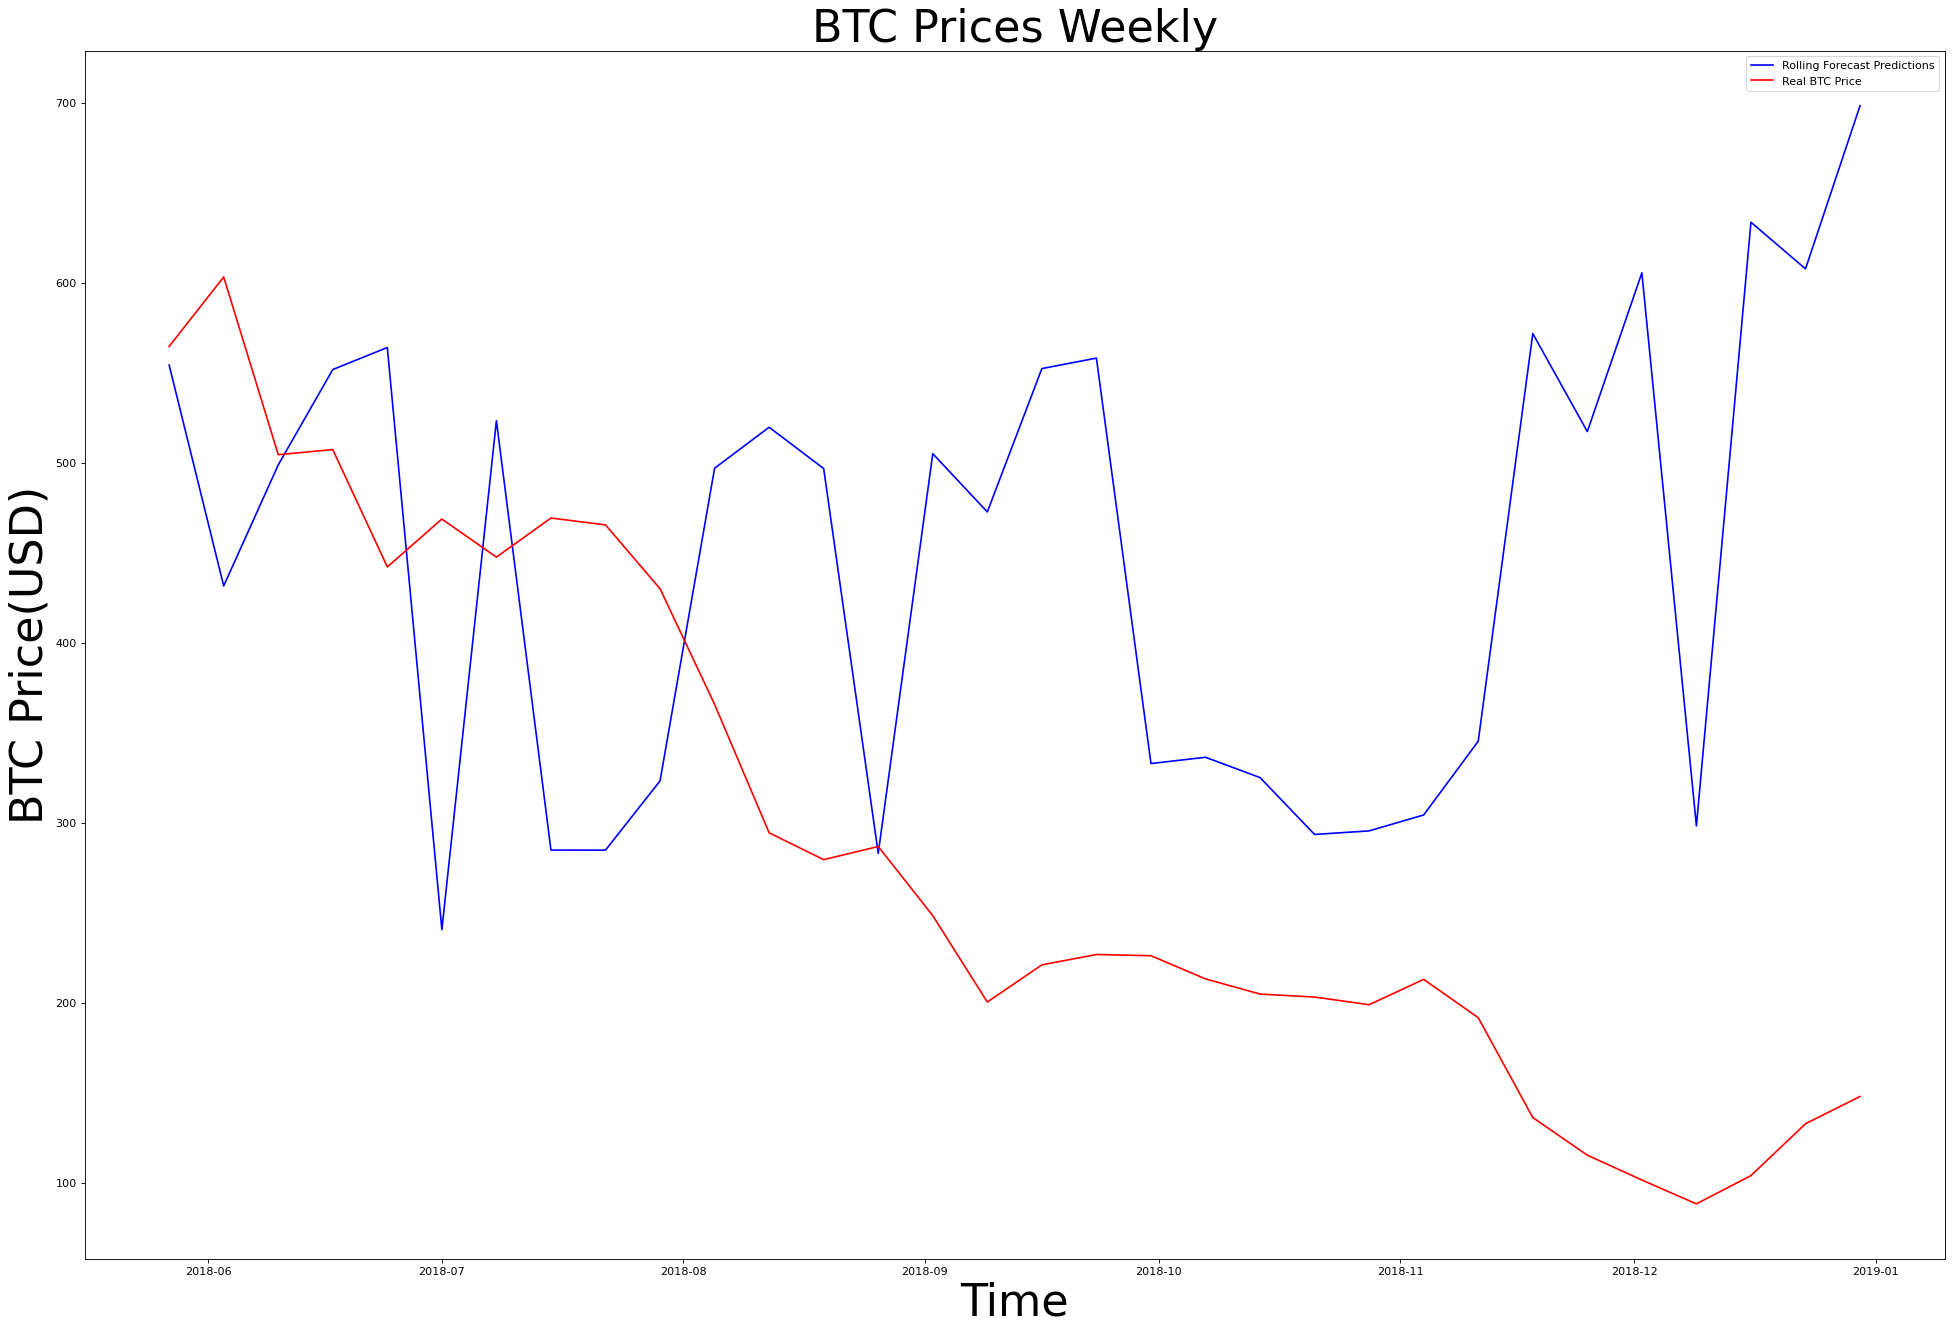

In [157]:
# The Prices of Bitcoin over time
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(X_test.index,predictions, color='blue', label='Rolling Forecast Predictions')
plt.plot(X_test.index,y_test, color='red', label='Real BTC Price')
# Same values are predicted with sliding window
#plt.plot(df_x_test.index,predictions_sw, color='green', label='Real BTC Price')
plt.title('BTC Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize = 40)
plt.legend()
plt.show()